# SEIQR pour essayer de comprendre la dynamique de l'épidémie covid-19 (en France)

_Disclamer: Je ne suis pas épidémiologiste._

## Modèle
Le modèle suppose 5 compartiments:
 - $S$: Compartiment des Succeptibles.
 - $E$: Compartiment des exposés (les personnes en incubation).
 - $I$: Compartiment des inféctés contagieux qui contaminent.
 - $Q$: Compartiemnt des infectés en quarantaine.
 - $R$: Compartiment des guéris et des morts (qui sont confondus dans ce
   modèle).

## Dynamique
La dynamique du modèle est régie pas les équations suivantes:
 - $\frac{dS(t)}{dt} = -\beta\frac{S(t)I(t)}{N}$
 - $\frac{dE(t)}{dt} = \beta\frac{S(t)I(t)}{N} - aE(t)$
 - $\frac{dI(t)}{dt} = aE(t)-\gamma I(t)$
 - $\frac{dQ(t)}{dt} = \gamma I(t) - \delta Q(t)$
 - $\frac{dR(t)}{dt} = \delta Q(t)$

Sur les paramètres, on peut dire que:
 - $R_0=\frac{\beta}{\gamma}$, et ça c'est interessant, car on connait $R_0$
   (enfin on est capable d'aller dans la littérature chercher des valeurs
   plausibles).
 - $a^{-1}$ est le temps moyen d'incubation.
 - $\gamma^{-1}$ est le temps moyen pendant lequel un individu infectieux
   contamine.
 - $\delta^{-1}$ est le temps moyen qu'un indivudu contagieux qui ne contamine
   plus (car isolé) reste en traitement avant mort ou guérison.

## Initialisation
 - $I(0)$: nombre d'infectés non guéris et non morts (oui de considérer que tous le monde est contagieux dès le départ,
   cela induit peut être le fait de voir le pic 1 ou 2 jours trop tôt).
 - $E(0)$ de telle manière à avoir $aE(0)$ qui correspond au flux (en utilisant
   les données de la veille).
 - $Q(0)=0$, puisque j'ai mis tous les infectés dans $I$.
 - $R(0)=$, guéris + morts.
 - $S(0) = N-E(0)-I(0)-Q(0)-R(0)$.

## Le code

Cette partie ne vous interesse pas forcément. Si vous voulez juste utiliser, executez les cellules une à une, et rendez-vous à la partie utilisation.

In [1]:
# Ce dont on a besoin
import collections
from typing import List
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as tic
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
# Les types dont on a besoin
State = collections.namedtuple("State", ("t", "S", "E", "I", "Q", "R"))

SimulationParam = collections.namedtuple(
    "SimulationParam",
    ("incubation_period", "infection_period", "quarantaine_period", "R0"),
)

InitializationParam = collections.namedtuple(
    "InitializationParam",
    ( 
        "infected_today",
        "infected_yesterday",
        "recovered_today",
        "recovered_yesterday",
        "population_size",
    ),
)

In [3]:
# La fonction principale de simulation
def simu(
    sim_par: SimulationParam, init_par: InitializationParam, timelimit: int = 365 * 24
) -> List[State]:
    """Perform a simulation

    Parameters:
      - sim_par: A simulation parameter, all periods should be provided in days
      - init_par: A initialization parameter, death are counted with recovered
      - timeelimit: in hour, default (one year)

    Returns:
      - List of state, time in step is in hour.
    """

    a = 1 / (sim_par.incubation_period * 24)
    γ = 1 / (sim_par.infection_period * 24)
    δ = 1 / (sim_par.quarantaine_period * 24) if sim_par.quarantaine_period > 0 else 1 
    β = sim_par.R0 * γ 

    s_E = ( 
        init_par.infected_today
        - init_par.infected_yesterday
        + init_par.recovered_today
        - init_par.recovered_yesterday
    ) / (24 * a)
    s_I = init_par.infected_today
    s_R = init_par.recovered_today
    s_Q = 0 
    state = State(
        0, init_par.population_size - s_E - s_I - s_R - s_Q, s_E, s_I, s_R, s_Q
    ) 

    states = [state]
    for t in range(1, 1 + timelimit):
        succ_to_exposed = β * state.S * state.I / init_par.population_size
        exposed_to_infected = a * state.E
        infected_to_quarantaine = γ * state.I
        quarantaine_to_recovered = δ * state.Q

        state = State(
            t=t,
            S=state.S - succ_to_exposed,
            E=state.E + succ_to_exposed - exposed_to_infected,
            I=state.I + exposed_to_infected - infected_to_quarantaine,
            Q=state.Q + infected_to_quarantaine - quarantaine_to_recovered,
            R=state.R + quarantaine_to_recovered,
        )

        states.append(state)
    return states

In [4]:
# La fonction de dessin
def do_plots(
    today: datetime.datetime,
    sim_par: SimulationParam,
    init_par: InitializationParam,
    ax=plt,
    label=None,
    to_plot=lambda x: x.I + x.Q,
    horizon=365,
):
    """Plot a simulation

    Parameters:
      - today: datetime object describing the time t=0.
      - sim_par: A simulation parameter, all periods should be provided in days
      - init_par: A initialization parameter, death are counted with recovered
      - ax: ax to plot (by default plt)
      - label
      - to_plot: a lambda function extracting fields to plot from a state
      - horizon: in days
    """

    sim = simu(sim_par, init_par, timelimit=horizon*24)
    ax.plot(
        [today + datetime.timedelta(x.t / 24) for x in sim],
        [to_plot(x) for x in sim],
        label=label,
    )
    if not hasattr(ax, 'yaxis'):
        ax = ax.gca()
    ax.yaxis.set_major_formatter(tic.EngFormatter(sep=""))
    ax.grid(True)


## Utilisation

Il convient dans un premier temps de définir ce qui va nous servir pour initialiser le modèle. J'utilise pour cela les données du 3 mars en France.

In [5]:
today = datetime.datetime(2020,3,3)
ip = InitializationParam(
    infected_today=212, 
    infected_yesterday=191, 
    recovered_today=16, 
    recovered_yesterday=15, 
    population_size=67e6
)

On fait tout d'abort un premier petit graphe avec une condition de simulation simple:

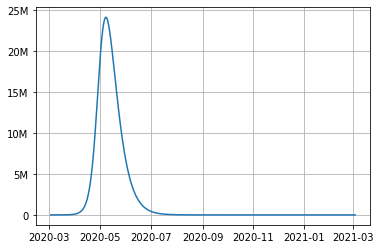

In [6]:
sp = SimulationParam(
        incubation_period=5.4, 
        infection_period=2, 
        quarantaine_period=10, 
        R0=3)
do_plots(today, sp, ip)

Puis un graphe qui bouge en fonction de $R_0$ et de la période d'incubation.

In [7]:
my_computer_is_slow = False
@interact(
    R0=widgets.FloatSlider(3.5,min=1,max=5,continuous_update=not my_computer_is_slow),
    incub=widgets.FloatSlider(5.4,min=2,max=14,continuous_update=not my_computer_is_slow),
    horizon=widgets.IntSlider(250,min=10,max=366,continuous_update=not my_computer_is_slow)
)
def a_plot(R0, incub, horizon):
    fig,(ax1,ax2) = plt.subplots(2,1, figsize=(12,8))
    sp_ref = SimulationParam(
        incubation_period=5.4, 
        infection_period=2, 
        quarantaine_period=10, 
        R0=1.5)
    sp = SimulationParam(
        incubation_period=incub, 
        infection_period=2, 
        quarantaine_period=10, 
        R0=R0)
    do_plots(today, sp_ref, ip, ax=ax1, label=f'$R_0={sp_ref.R0:.2f}, incub={sp_ref.incubation_period:.2f}$', horizon=horizon)
    do_plots(today, sp, ip, ax=ax1, label=f'$R_0={sp.R0:.2f}, incub={sp.incubation_period:.2f}$', horizon=horizon)
    ax1.legend()
    ax1.set_ylabel('I(t)+Q(t)')
    do_plots(today, sp_ref, ip, ax=ax2, label=f'$R_0={sp_ref.R0:.2f}, incub={sp_ref.incubation_period:.2f}$', to_plot=lambda x: x.I+x.Q+x.R, horizon=horizon)
    do_plots(today, sp, ip, ax=ax2, label=f'$R_0={sp.R0:.2f}, incub={sp.incubation_period:.2f}$', to_plot=lambda x: x.I+x.Q+x.R, horizon=horizon)
    ax2.legend()
    ax2.set_ylabel('I(t)+Q(t)+R(t)')
    

interactive(children=(FloatSlider(value=3.5, description='R0', max=5.0, min=1.0), FloatSlider(value=5.4, descr…

Avec ce précédent graphique, on peut constater plein de choses, par exemple:

 - $R_0$ a un influence sur la hauteur du pic, donc du nombre de personne à traiter (dont une partie devra être hospitalisé).
 - la péride d'incubation a très peu d'influence sur la hauteur des pics et sur l'équilibre atteint, mais ça retarde la progression.
 
Ma conclusion (qui n'engage que moi): On comprend aussi que si $R_0$ n'est pas faible le système de santé n'arrivera pas à traiter en même temps tous les patients. Or notre moyen d'action est sur $\beta$ et comme $R_0=\frac{\beta}{\gamma}$, nous pouvons tenir $R_0$ le plus faible possible en limitant la propagation (diminution contacts, lavage des mains, isolation des contagieux…).